## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [104]:
# pandas and numpy
import spacy
import pandas as pd
import numpy as numpy
!pip install en_core_web_sm
# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()
import random
# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models
#
import re
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [105]:
# load data 
# ----------
congress_tweets = pd.read_csv("/Users/stacyworkuser/Downloads/data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
random.seed(123)
congress_tweets = congress_tweets.sample(n=5000, replace=False)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
517138,1.204430e+18,RepBonnie,2019-12-10T10:51:23-05:00,The #FUTUREAct improves the self-sufficiency o...,Bonnie Watson Coleman,Rep,3-Jan-15,2/6/1945,F,NJ,12,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568"
99131,1.197580e+18,RepSpeier,2019-11-21T13:16:19-05:00,"David Holmes said 14,000 have died in Ukraine'...",Jackie Speier,Rep,3-Jan-13,5/14/1950,F,CA,14,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
940872,1.267150e+18,RepBryanSteil,2020-05-31T13:27:53-04:00,"On this Sunday, more than ever, I am praying f...",Bryan Steil,Rep,3-Jan-19,3/30/1981,M,WI,1,Republican,"1,405,284","1,382,536","1,620,985","1,407,966"
823012,1.286690e+18,RepRWilliams,2020-07-24T11:51:18-04:00,"RT @HouseGOP Reminder: For House Democrats, th...",Roger Williams,Rep,3-Jan-13,9/13/1949,M,TX,25,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
172199,1.294020e+18,RepJasonCrow,2020-08-13T17:03:44-04:00,This is exactly why I joined 174 of my House c...,Jason Crow,Rep,3-Jan-19,3/15/1979,M,CO,6,Democrat,"1,202,484","1,338,870","1,323,102","1,185,243"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [106]:
text = congress_tweets['text']

In [107]:
nlp = en_core_web_sm.load()                 # load the small language model en_core_web_sm

## Iterate through each tweet
for text in congress_tweets['text']:
    # Tokenize the text using spaCy
    doc = nlp(text)
    
    # Extract the tokens from the tokenized text
    spacy_words = [token.text for token in doc]
    
    # Display the tokenized words
    print(f"Tokenized words: {spacy_words}")

Tokenized words: ['The', '#', 'FUTUREAct', 'improves', 'the', 'self', '-', 'sufficiency', 'of', '#', 'HBCUs', 'and', '#', 'MSIs', ',', 'while', 'strengthening', 'their', 'ability', 'to', 'serve', 'low', '-', 'income', 'students', '.', 'Congress', 'must', 'protect', 'these', 'institutions', 'and', 'reauthorize', 'critical', 'funding', '#', 'ForTheFUTURE', '.', 'http://pbs.twimg.com/media/ELb9P53WkAEJXju.jpg']
Tokenized words: ['David', 'Holmes', 'said', '14,000', 'have', 'died', 'in', 'Ukraine', "'s", 'war', 'with', 'Russia', 'so', 'far', '.', 'Gordon', 'Sondland', 'knows', 'Donald', 'Trump', 'does', "n't", 'give', 'an', '[', 'expletive', ']', 'about', 'it', '.', 'Big', 'stuff', 'is', "n't", 'our', 'dead', 'allies', ',', 'it', "'s", 'Donald', 'Trump', "'s", 'campaign', '.']
Tokenized words: ['On', 'this', 'Sunday', ',', 'more', 'than', 'ever', ',', 'I', 'am', 'praying', 'for', 'an', 'end', 'to', 'prejudice', 'and', 'abuse', '.', 'And', 'for', 'an', 'end', 'to', 'the', 'violence', '.', '

In [202]:
print(congress_tweets.columns)

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'tokens_reduced', 'num_tokens',
       'hashtags', 'polarity', 'subjectivity'],
      dtype='object')


In [109]:
from string import punctuation  # note that this is a base library
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [110]:
from spacy.lang.en.stop_words import STOP_WORDS
list(STOP_WORDS)[0:10]

['made',
 'too',
 'myself',
 'until',
 'into',
 'wherever',
 '’d',
 'seeming',
 'somewhere',
 'between']

In [111]:

# initalize an empty list
tokens_reduced = []
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc


In [112]:
# apply our new function to our text object from above
tokens_reduced = rem_punc_stop(text)

# view the first 5 tokens
tokens_reduced[0:5]


['Packers', 'strike', 'This', '200th', 'meeting']

In [113]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # can use apply here 
congress_tweets['tokens'] # visualize

517138    [The, FUTUREAct, improves, selfsufficiency, HB...
99131     [David, Holmes, said, 14000, died, Ukraines, w...
940872    [On, Sunday, I, praying, end, prejudice, abuse...
823012    [RT, HouseGOP, Reminder, For, House, Democrats...
172199    [This, exactly, I, joined, 174, House, colleag...
                                ...                        
597289    [We, need, honor, John, Lewis, bringing, bill,...
439373    [The, House, passed, bill, combat, shady, big,...
470965    [RT, GOPLeader, RT, thank, keeping, shelves, s...
366578    [RT, NWSNewOrleans, 2PM, Sunday, Hurricane, Ma...
937520    [Packers, strike, This, 200th, meeting, best, ...
Name: tokens, Length: 5000, dtype: object

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1:Histogram of word count

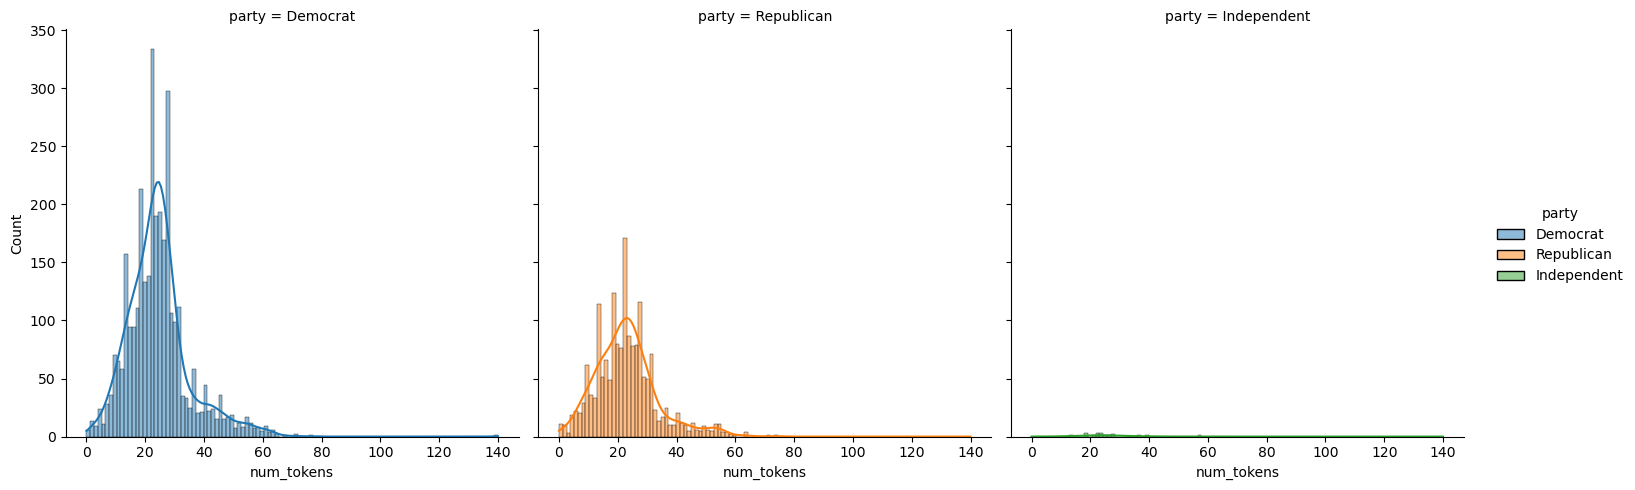

In [114]:
# Apply the function to each tweet in the DataFrame
congress_tweets['tokens_reduced'] = congress_tweets['text'].apply(rem_punc_stop)

# Calculate the number of tokens for each tweet
congress_tweets['num_tokens'] = congress_tweets['tokens_reduced'].apply(len)

# Plot histograms of token count by party
sns.displot(congress_tweets, x="num_tokens", hue="party", col="party", kde=True)
plt.show()

### EDA 2: frequently used hashtags 

In [115]:
# Extract hashtags from tweet text
def extract_hashtags(text):
    return re.findall(r'#(\w+)', text)

# Apply the function to each tweet in the df
congress_tweets['hashtags'] = congress_tweets['text'].apply(extract_hashtags)
democrat_hashtags = congress_tweets[congress_tweets['party'] == 'Democrat']['hashtags']
republican_hashtags = congress_tweets[congress_tweets['party'] == 'Republican']['hashtags']

# Flatten the lists of hashtags
democrat_hashtags = [tag for sublist in democrat_hashtags for tag in sublist]
republican_hashtags = [tag for sublist in republican_hashtags for tag in sublist]

# Count the frequency of each hashtag
democrat_hashtag_counts = pd.Series(democrat_hashtags).value_counts().head(50)
republican_hashtag_counts = pd.Series(republican_hashtags).value_counts().head(50)


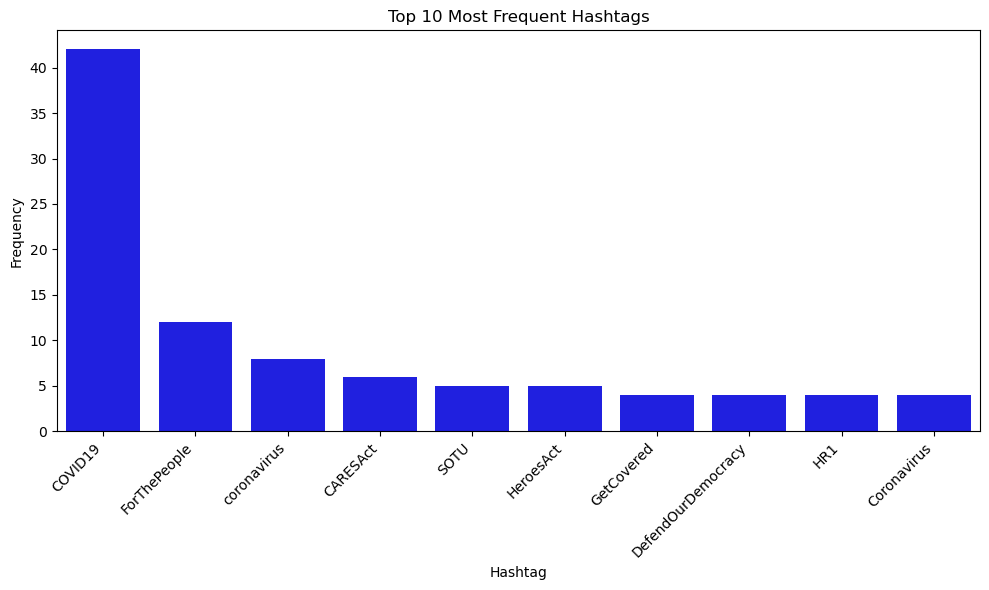

In [116]:

# Plot the most frequent hashtags
plt.figure(figsize=(10, 6))
sns.barplot(x=hashtag_counts.index, y=hashtag_counts.values, color="blue")
plt.title('Top 10 Most Frequent Hashtags')
plt.xlabel('Hashtag')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/w3/tbfkszb55sz5zxq7gjbx_mlh0000gp/T/ipykernel_17150/3282259717.py:7: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
/Users/stacyworkuser/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


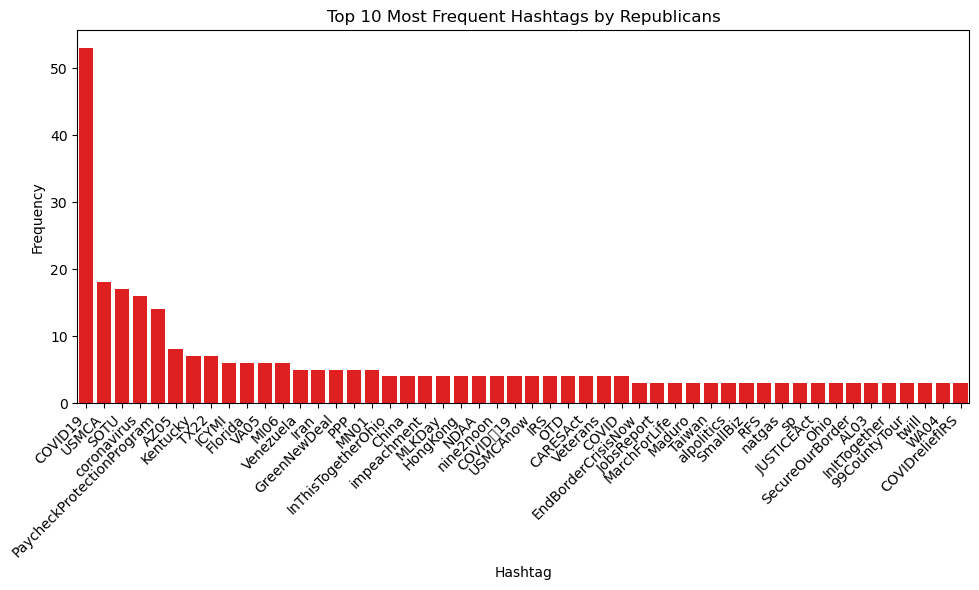

In [117]:

plt.figure(figsize=(10, 6))
sns.barplot(x=republican_hashtag_counts.index, y=republican_hashtag_counts.values, color='red')
plt.title('Top 10 Most Frequent Hashtags by Republicans')
plt.xlabel('Hashtag')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [118]:
# create a feature colum of sentiment polarity
# ---------- 
# create the "tokens" column again 
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# view
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_reduced,num_tokens,hashtags,polarity,subjectivity
517138,1.204430e+18,RepBonnie,2019-12-10T10:51:23-05:00,The #FUTUREAct improves the self-sufficiency o...,Bonnie Watson Coleman,Rep,3-Jan-15,2/6/1945,F,NJ,...,"1,601,933","2,148,278","2,125,101","1,477,568",The FUTUREAct improves selfsufficiency HBCUs M...,"[The, FUTUREAct, improves, selfsufficiency, HB...",18,"[FUTUREAct, HBCUs, MSIs, ForTheFUTURE]",0.000000,0.800
99131,1.197580e+18,RepSpeier,2019-11-21T13:16:19-05:00,"David Holmes said 14,000 have died in Ukraine'...",Jackie Speier,Rep,3-Jan-13,5/14/1950,F,CA,...,"4,483,814","8,753,792","7,854,285","4,839,958",David Holmes said 14000 died Ukraines war Russ...,"[David, Holmes, said, 14000, died, Ukraines, w...",24,[],-0.033333,0.500
940872,1.267150e+18,RepBryanSteil,2020-05-31T13:27:53-04:00,"On this Sunday, more than ever, I am praying f...",Bryan Steil,Rep,3-Jan-19,3/30/1981,M,WI,...,"1,405,284","1,382,536","1,620,985","1,407,966",On Sunday I praying end prejudice abuse And en...,"[On, Sunday, I, praying, end, prejudice, abuse...",11,[],0.000000,0.000
823012,1.286690e+18,RepRWilliams,2020-07-24T11:51:18-04:00,"RT @HouseGOP Reminder: For House Democrats, th...",Roger Williams,Rep,3-Jan-13,9/13/1949,M,TX,...,"4,685,047","3,877,868","3,308,124","4,569,843",RT HouseGOP Reminder For House Democrats legis...,"[RT, HouseGOP, Reminder, For, House, Democrats...",21,[],0.600000,0.800
172199,1.294020e+18,RepJasonCrow,2020-08-13T17:03:44-04:00,This is exactly why I joined 174 of my House c...,Jason Crow,Rep,3-Jan-19,3/15/1979,M,CO,...,"1,202,484","1,338,870","1,323,102","1,185,243",This exactly I joined 174 House colleagues cal...,"[This, exactly, I, joined, 174, House, colleag...",15,[],0.150000,0.375


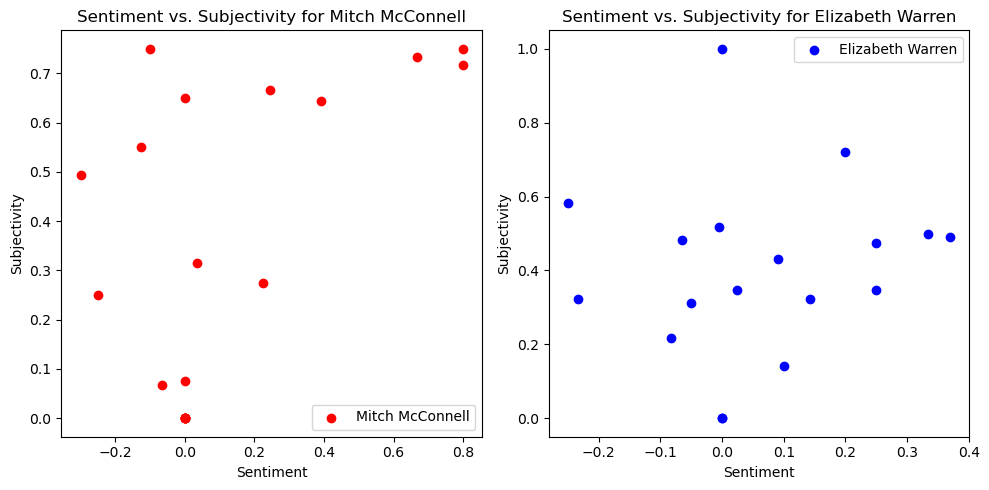

In [119]:
# Filter tweets for Mitch McConnell and Bernie Sanders
mitch_tweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Mitch McConnell']
warren_tweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Elizabeth Warren']

# Plot scatterplots for sentiment against subjectivity
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(mitch_tweets['polarity'], mitch_tweets['subjectivity'], color='red', label='Mitch McConnell')
plt.title('Sentiment vs. Subjectivity for Mitch McConnell')
plt.xlabel('Sentiment')
plt.ylabel('Subjectivity')
plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(warren_tweets['polarity'], warren_tweets['subjectivity'], color='blue', label='Elizabeth Warren')
plt.title('Sentiment vs. Subjectivity for Elizabeth Warren')
plt.xlabel('Sentiment')
plt.ylabel('Subjectivity')
plt.legend()

plt.tight_layout()
plt.show()

McConnell's tweets trend more on subjectivity compared to Warren. And has higher positive sentiment compared to warren, who tweets closer to neutral sentiment. I'm not surprised as I know that Mitch McConnel has more hyperbolic speech patterns-- he also has the job of unifying his party so it would make sense that his tweets are more subjective/ opinionated. 

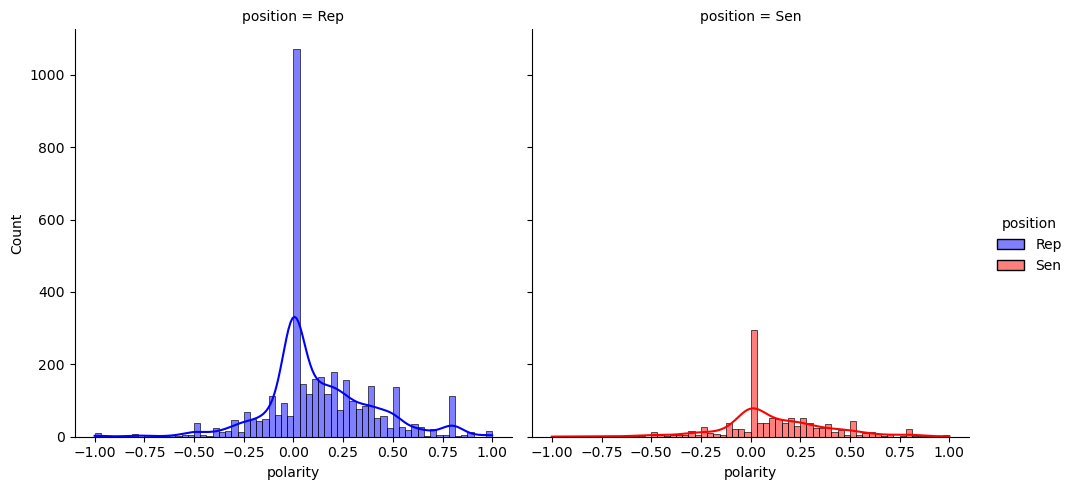

In [120]:
# Plot histogram of polarity by position
sns.displot(congress_tweets,            # specify data
            x="polarity",               # specify x-axis feature
            hue="position",                # color by political party
            col="position",                # separate histograms by political party
            palette={"Rep": "blue", "Sen": "red"},  # customize colors for each party
            kde=True)                   # include kernel density estimation
plt.show()

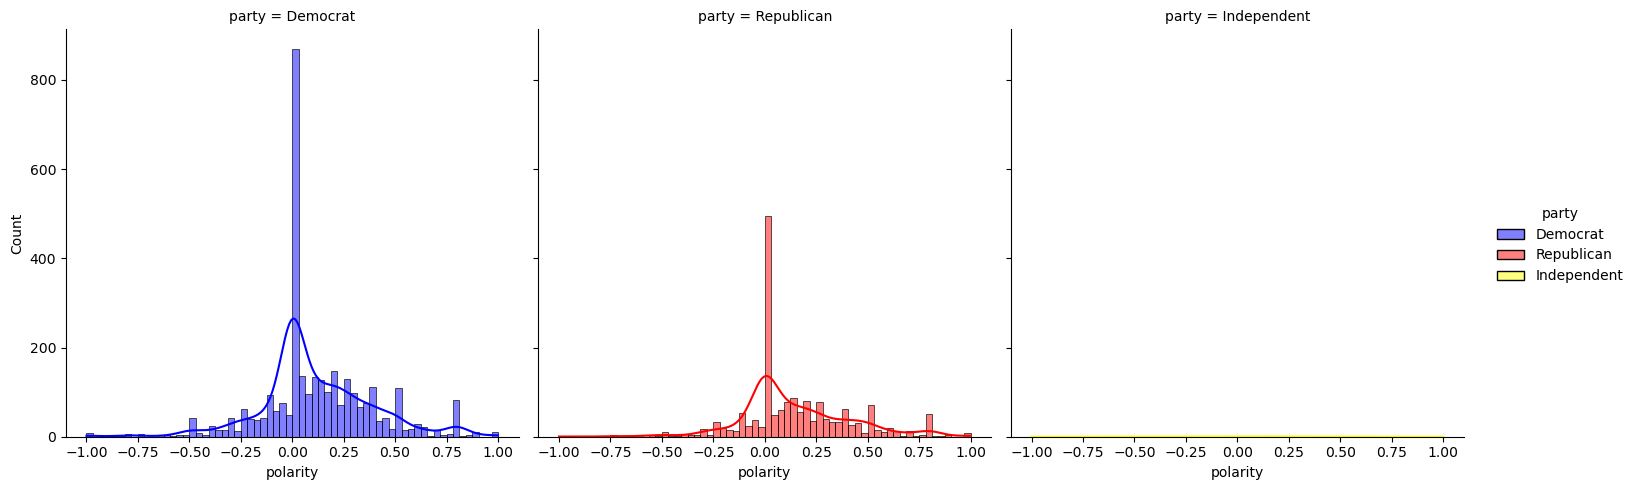

In [122]:
# Plot histogram of polarity by political party
sns.displot(congress_tweets,            # specify data
            x="polarity",               # specify x-axis feature
            hue="party",                # color by political party
            col="party",                # separate histograms by political party
            palette={"Democrat": "blue", "Republican": "red", "Independent": "yellow"},  # customize colors for each party
            kde=True)                   # include kernel density estimation
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [193]:
engineered_features_df = pd.DataFrame({
    'polarity': congress_tweets['polarity'],
    'subjectivity': congress_tweets['subjectivity'],
    'num_tokens': congress_tweets['num_tokens'],
    'party': congress_tweets['party'],
    'position': congress_tweets['position'],

})
encoded_features_df = pd.get_dummies(engineered_features_df, columns=['party', 'position'])

,polarity,subjectivity,num_tokens,party_Democrat,party_Independent,party_Republican,position_Rep,position_Sen
517138,0.000000,0.800,18,1,0,0,1,0
99131,-0.033333,0.500,24,1,0,0,1,0
940872,0.000000,0.000,11,0,0,1,1,0
823012,0.600000,0.800,21,0,0,1,1,0
172199,0.150000,0.375,15,1,0,0,1,0


In [194]:
encoded_features_df.head()

,polarity,subjectivity,num_tokens,party_Democrat,party_Independent,party_Republican,position_Rep,position_Sen
517138,0.000000,0.800,18,1,0,0,1,0
99131,-0.033333,0.500,24,1,0,0,1,0
940872,0.000000,0.000,11,0,0,1,1,0
823012,0.600000,0.800,21,0,0,1,1,0
172199,0.150000,0.375,15,1,0,0,1,0


### Bag-of-words or Tf-idf

In [218]:
# Frequency Based featurization
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning.

# apply tf-idf vectorizer to our data
tfidf_matrix =  tf.fit_transform(congress_tweets['text'])

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

In [224]:
# Convert the TF-IDF matrix to a dense matrix
dense_matrix = tfidf_matrix.todense()

# Convert the dense matrix to a NumPy array
tf_array = np.asarray(dense_matrix)


### Word Embedding

In [242]:
import numpy as np
import pandas as pd
import gensim

# apply CBOW Word2vec model to our cfpb data 
# ----------
model = gensim.models.Word2Vec(congress_tweets['tokens'],    # specify data - sentences
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000, # sample size 
                               workers = 1)       # set cores to 1 to ensure this embeddings are fully reproducible

# create an array for the size of the corpus
# ----------
# create empty list
empty_list_embeddings_means = []

# loop over each each token
for puppy in congress_tweets['text']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, puppy))
    
# convert the list to array
doc_average_embeddings = np.array(empty_list_embeddings_means) 

# convert word embeddings into dataframe
# ----------
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

Accuracy: 0.649


/Users/stacyworkuser/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [231]:
# Make sure the indices of congress_tweets match the order of document vectors in word2vec_features_df
congress_tweets.reset_index(drop=True, inplace=True)

# Concatenate word2vec_features_df with 'party' and 'position' columns from congress_tweets
word2vec_features_df = pd.concat([word2vec_features_df, congress_tweets[['party', 'position']]], axis=1)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [196]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
#
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
# Features Data
# Model 1: Predict republicans (dropping independents)---------- 
features_df = encoded_features_df[encoded_features_df['party_Independent'] != 1]
X_party = features_df.drop(columns=['party_Republican', 'party_Democrat'])
y_party = features_df['party_Republican']  # Target variable for party prediction (Republican)
X_train_party, X_test_party, y_train_party, y_test_party = train_test_split(X_party, y_party, test_size=0.2, random_state=42)
logit_reg_party = LogisticRegression(random_state=75)
logit_model_party = logit_reg_party.fit(X_train_party, y_train_party)
y_pred_party = logit_model_party.predict(X_test_party)

# Print classification reports
print("Classification Report for Party Prediction:")
print(classification_report(y_test_party, y_pred_party))

#Model 2: Predict positions 

X_position = encoded_features_df.drop(columns=['position_Sen', 'position_Rep'])
y_position = encoded_features_df['position_Sen']  # Target variable for position prediction
X_train_position, X_test_position, y_train_position, y_test_position = train_test_split(X_position, y_position, test_size=0.2, random_state=42)
logit_reg_position = LogisticRegression(random_state=75)
logit_model_position = logit_reg_position.fit(X_train_position, y_train_position)

y_pred_party = logit_model_party.predict(X_test_party)
y_pred_position = logit_model_position.predict(X_test_position)

print("\nClassification Report for Position Prediction (Senator):")
print(classification_report(y_test_position, y_pred_position))


Classification Report for Party Prediction:
              precision    recall  f1-score   support

           0       0.69      0.96      0.80       672
           1       0.56      0.11      0.18       325

    accuracy                           0.68       997
   macro avg       0.62      0.53      0.49       997
weighted avg       0.65      0.68      0.60       997


Classification Report for Position Prediction (Senator):
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       782
           1       1.00      0.01      0.03       218

    accuracy                           0.79      1000
   macro avg       0.89      0.51      0.45      1000
weighted avg       0.83      0.79      0.69      1000



In [229]:
from sklearn.metrics import accuracy_score
#model 3: tfidf and party 
# Split the data into features (X) and target variable (y)
X = dense_matrix  # TF-IDF features
y = congress_tweets['party']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert X_train and y_train to NumPy arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

# Initialize and fit the logistic regression model
logistic_regression = LogisticRegression(random_state=75)
logistic_regression.fit(X_train, y_train)
X_test = np.asarray(X_test)

# Predict the party affiliation on the test set
y_pred = logistic_regression.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.731
Classification Report:
              precision    recall  f1-score   support

    Democrat       0.72      0.95      0.82       644
 Independent       0.00      0.00      0.00         3
  Republican       0.80      0.33      0.47       353

    accuracy                           0.73      1000
   macro avg       0.51      0.43      0.43      1000
weighted avg       0.75      0.73      0.69      1000



/Users/stacyworkuser/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stacyworkuser/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stacyworkuser/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [230]:
#model 4: tfidf and position 
# Split the data into features (X) and target variable (y)
X = dense_matrix  # TF-IDF features
y = congress_tweets['position']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert X_train and y_train to NumPy arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

# Initialize and fit the logistic regression model
logistic_regression = LogisticRegression(random_state=75)
logistic_regression.fit(X_train, y_train)
X_test = np.asarray(X_test)

# Predict the party affiliation on the test set
y_pred = logistic_regression.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

         Rep       0.79      1.00      0.88       782
         Sen       0.90      0.04      0.08       218

    accuracy                           0.79      1000
   macro avg       0.84      0.52      0.48      1000
weighted avg       0.81      0.79      0.71      1000



In [245]:
y = congress_tweets['party'] # Target variable

# split into training
X_train, X_test, y_train, y_test = train_test_split(word2vec_features_df, # specify features
                                                    y,                    # specify labels
                                                    train_size = .80,     # specify training split
                                                    test_size=0.20,       # specify test split
                                                    random_state = 10)    # set seed
# inititialize a model
logit_reg = LogisticRegression()

# fit on training
logit_model = logit_reg.fit(X_train, 
                            y_train.ravel())

# predict on test data
y_pred = logit_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.649
Accuracy: 0.649
Classification Report:
              precision    recall  f1-score   support

    Democrat       0.65      0.99      0.79       647
 Independent       0.00      0.00      0.00         4
  Republican       0.57      0.02      0.04       349

    accuracy                           0.65      1000
   macro avg       0.41      0.34      0.28      1000
weighted avg       0.62      0.65      0.52      1000



/Users/stacyworkuser/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/stacyworkuser/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stacyworkuser/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision an

In [246]:
y = congress_tweets['position'] # Target variable

# split into training
X_train, X_test, y_train, y_test = train_test_split(word2vec_features_df, # specify features
                                                    y,                    # specify labels
                                                    train_size = .80,     # specify training split
                                                    test_size=0.20,       # specify test split
                                                    random_state = 10)    # set seed
# inititialize a model
logit_reg = LogisticRegression()

# fit on training
logit_model = logit_reg.fit(X_train, 
                            y_train.ravel())

# predict on test data
y_pred = logit_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.758
Accuracy: 0.758
Classification Report:
              precision    recall  f1-score   support

         Rep       0.76      1.00      0.86       758
         Sen       0.00      0.00      0.00       242

    accuracy                           0.76      1000
   macro avg       0.38      0.50      0.43      1000
weighted avg       0.57      0.76      0.65      1000



/Users/stacyworkuser/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stacyworkuser/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stacyworkuser/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Two Combined Models

In [247]:
# two models ([best text features- which was tfidf + non-text features] *senator/representative (position)
#get non text features
other_features= congress_tweets[['joined_congress_date', 
                                     'birthday', 
                                     'gender', 
                                     'state',
                                     'trump_2016_state_share',
                                     'clinton_2016_state_share',
                                     'obama_2012_state_share',
                                     'romney_2012_state_share']]

# get dummies of non-text features
other_features_dummies = pd.get_dummies(other_features).reset_index(drop = True)
other_features_dummies.head()

,joined_congress_date_10-Apr-18,joined_congress_date_10-Jul-18,joined_congress_date_10-Mar-05,joined_congress_date_10-May-94,joined_congress_date_10-Sep-15,joined_congress_date_11-Apr-13,joined_congress_date_11-Dec-07,joined_congress_date_11-Jul-17,joined_congress_date_11-Mar-08,joined_congress_date_12-Dec-13,...,"romney_2012_state_share_634,892","romney_2012_state_share_647,744","romney_2012_state_share_692,634","romney_2012_state_share_710,746","romney_2012_state_share_730,617","romney_2012_state_share_740,600","romney_2012_state_share_754,175","romney_2012_state_share_891,325","romney_2012_state_share_92,698","romney_2012_state_share_971,869"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [253]:
y = congress_tweets['position'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(other_features_dummies,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility

logit_reg = LogisticRegression(max_iter=500)

logit_model = logit_reg.fit(X_train,         # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the label dataset
y_pred = logit_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         Rep       0.99      1.00      0.99       758
         Sen       1.00      0.96      0.98       242

    accuracy                           0.99      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.99      0.99      1000



In [250]:

tf_df = pd.DataFrame(dense_matrix)
#combine data
final_df=other_features_dummies.join(tf_df)
#check
#change all data to strings 
final_df.columns=final_df.columns.astype(str)

In [254]:
y = congress_tweets['position'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(final_df,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility

logit_reg = LogisticRegression(max_iter=500)

logit_model = logit_reg.fit(X_train,         # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the label dataset
y_pred = logit_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         Rep       0.98      1.00      0.99       758
         Sen       1.00      0.94      0.97       242

    accuracy                           0.98      1000
   macro avg       0.99      0.97      0.98      1000
weighted avg       0.99      0.98      0.98      1000



## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Standard preprocessing needs to be further customized because text is not one size fits all. There are domain specific terms, or non standard punctuation (hashtags for example). And it's better to customize preprocessing to allow for downstream tasks such as running models.

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

Through my exploratory analysis, I wasn't able to observe differences between democrats and republicans nor senators and representatives. I am guessing that congress has rules about the type of tweets that are acceptable and go through a vetting process that shape sentiment patterns across the board. Another guess would be that tweets do not allow for enough variation for sentiments due to its character restriction.

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

Using a supervised learning approach is useful to validate because we are able to further drill down into the robustness of our observations. It also helps to use sueprvised learning to evaluate our feature engineering and understand whether it helps increase predictive performance. For social scientists, it adds to interpretability and theory grounding. 

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

Nontext and nontext + text together both worked very well. I think this makes sense because non-text variables in this corpus are extremely predictive of party and positions, while the text itself is not as useful-- especially as congress is likely to talk about similar topics and events, though they might have different takes. 